# **Metropolis Monte Carlo: Esercizio 2 punto 3**

### ⚠️ **PROGETTATO PER MacOS**. VERSIONE MULTI-CORE DEL PRIMO PUNTO, ESERCIZIO 2B. SU ALTRE PIATTAFORME USARE LA VERSIONE SINGLE CORE.

Implement a Metropolis MC loop to find the equilibrium configuration of a Ag cluster of fixed number of atoms 𝑁, randomly deposited on the flat ℎ 𝑥,𝑦 = 0 substrate. The energy of each configuration is evaluated by counting all bonds, (energies 𝐽0 and 𝐽1) formed by the 𝑁 atoms above the substrate. Each MC move consists in relocating one adatom at a randomly chosen site.

## *SVOLGIMENTO PUNTO 3*

Consider the MC loop at 𝑇 = 0 𝐾 and find the minimum-energy configuration of clusters from 𝑁 = 2 to 20. Check that in each case the global minimum is found by considering a long-enough MC loop and avoid metastable configurations by changing the random generator seed. Plot the energy of the minima 𝐸𝑚𝑖𝑛(𝑁) and the chemical potential 𝜇(𝑁) = 𝐸𝑚𝑖𝑛(𝑁)/𝑁. Analyze the results and interpret the alternating slope of 𝜇(𝑁) by considering the changes from one configuration to the next.

---

### 0) Importazioni e dati

In [1]:
import numpy as np
from CMS.MonteCarlo.MetropolisMonteCarlo import MetropolisMonteCarlo

In [2]:
temperature = 0   
L = (60,60) # dimensioni della griglia in unità di celle cristalline
N_atoms = np.arange(2, 21, 1) # numero di atomi da posizionare
seeds = [123413432, 4324234, 9876543, 5678901, 3456789, 8765432, 2345678,
        23, 4567890]

### 1) Simulazione

Da 2 atomi a 20\
Un solo seed, step=100_000: 20 secondi.\
9 seed diversi, step=300_000: 8minuti.

**ottimizzazioni**\
*mi aspetto velocizzazione del 20% (8min -> 6 e qualcosa)*
- no copia matrice trial_height
- update dell'energia invece di ricalcolo completo
- occupied_sites ora è una list, non più matrice di bool

9 seed diversi, step=300_000: 6minuti.

9 seed diversi, step=600_000, ma MULTI CORE: 3min 30s

In [3]:
from CMS.MonteCarlo.ioMMC import XYZwriter

In [4]:
import multiprocessing
from tqdm import tqdm
import numpy as np
# Ricordati di importare il NUOVO wrapper
from CMS.MonteCarlo.MetropolisMonteCarlo import run_ground_state_search

# Impostazioni simulazione
N_STEPS = 600_000
THERM_STEPS = 300_000
OUTPUT_FOLDER = "output/Es2_3" # Cartella base

if __name__ == '__main__':
    
    # 1. Creazione Tasks
    tasks = []
    for seed in seeds:
        for N in N_atoms:
            # Creiamo la tupla argomenti per il wrapper
            tasks.append((L[0], L[1], N, temperature, seed, N_STEPS, THERM_STEPS, OUTPUT_FOLDER))
            
    print(f"Lancio {len(tasks)} simulazioni per trovare gli stati fondamentali...")
    
    # 2. Esecuzione Parallela
    raw_results = []
    with multiprocessing.Pool() as pool:
        # Usiamo chunksize automatico o fisso (es. 10)
        for res in tqdm(pool.imap_unordered(run_ground_state_search, tasks), total=len(tasks)):
            raw_results.append(res)
            
    # 3. Post-Processing (Trova il minimo globale per ogni N)
    print("Elaborazione del minimo globale per ogni N...")
    
    best_results_dict = {} # Questo sarà il tuo results_dict finale
    
    for N, result in raw_results:
        # Se è la prima volta che vediamo questo N, o se abbiamo trovato un'energia minore
        if N not in best_results_dict:
            best_results_dict[N] = result
        else:
            if result.min_energy < best_results_dict[N].min_energy:
                best_results_dict[N] = result

Lancio 171 simulazioni per trovare gli stati fondamentali...


  0%|          | 0/171 [00:00<?, ?it/s]

100%|██████████| 171/171 [03:30<00:00,  1.23s/it]

Elaborazione del minimo globale per ogni N...


### 2) Analisi e plot

In [5]:
import matplotlib.pyplot as plt

#### Energia minima vs N

Nel modello _solid-on-solid_ considerato si ha che l'energia di un singolo atomo è lineare nel numero di primi vicini di quell'atomo $n^{(1)}_k$:

$$
\varepsilon_k = J_0 + n^{(1)}_k J_1
$$

pertanto, aggiungendo un atomo alla volta, ci si aspetta una variazione costante di energia tra un numero di atomi e l'altro. Se, ad esempio, ad ogni aggiunta di un atomo aumenta di 1 il numero di primi vicini di due atomi, allora si avrà un incremento (diminuzione perché $J_1<0$) dell'energia pari a $\Delta E = 2J_1$ per ogni nuovo atomo. La geometria reale è più complicata, pertanto non si osserva una linea retta perfetta, ma in generale la dipendenza resta **lineare nel numero di atomi**.

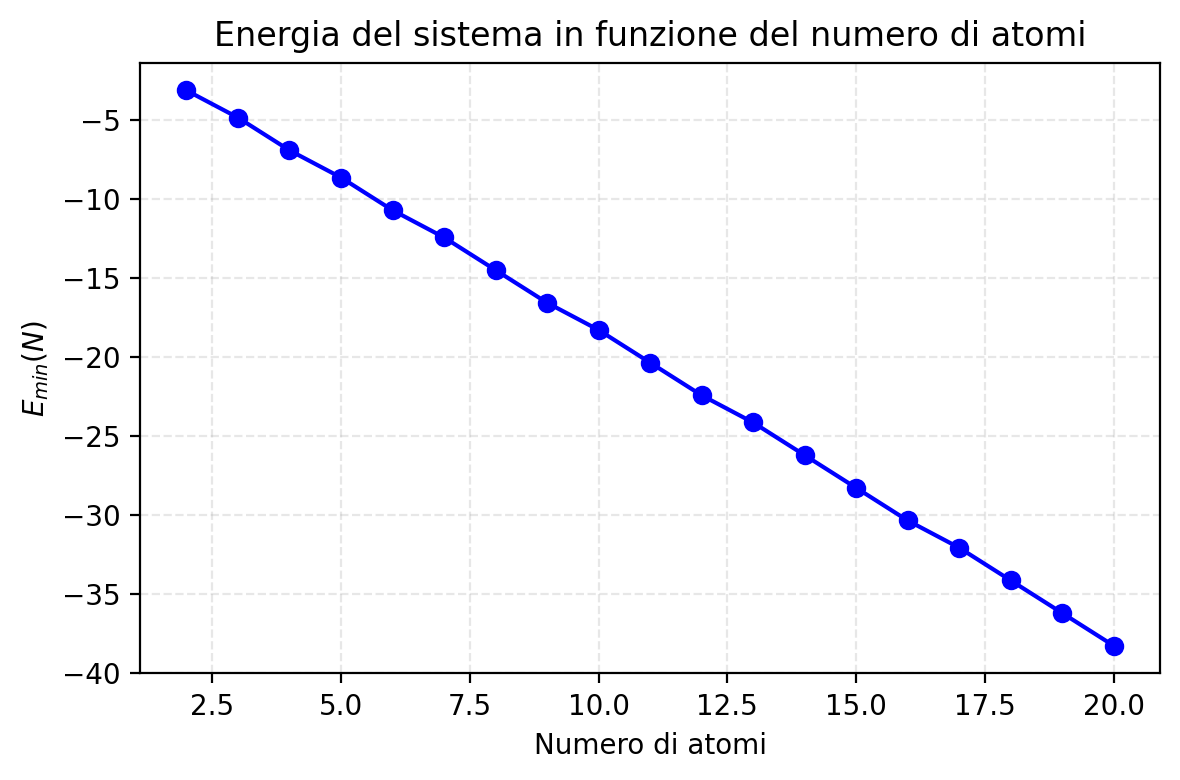

In [6]:
# plot energia minima v N
plt.figure(figsize=(6, 4), dpi=200)

x1 = N_atoms # da 2 atomi a 20
y1 = [best_results_dict[N].min_energy for N in N_atoms]

plt.plot(x1, y1, marker='o', color='blue')
plt.xlabel('Numero di atomi')
plt.ylabel(r'$E_{{min}}(N)$')
plt.title('Energia del sistema in funzione del numero di atomi')
plt.grid(linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Potenziale chimico vs N

Ci si aspetta di osservare dei minimi locali in corrispondenza dei massimi di primi vicini: se il numero di atomi è un quadrato perfetto, si potrà massimizzare il numero di atomi all'interno del cluster e quindi massimizzarne il numero di vicini. Anche se l'energia minima è lineare nel numero di atomi, ci si aspetta che il potenziale chimico risalga dopo ogni quadrato perfetto.

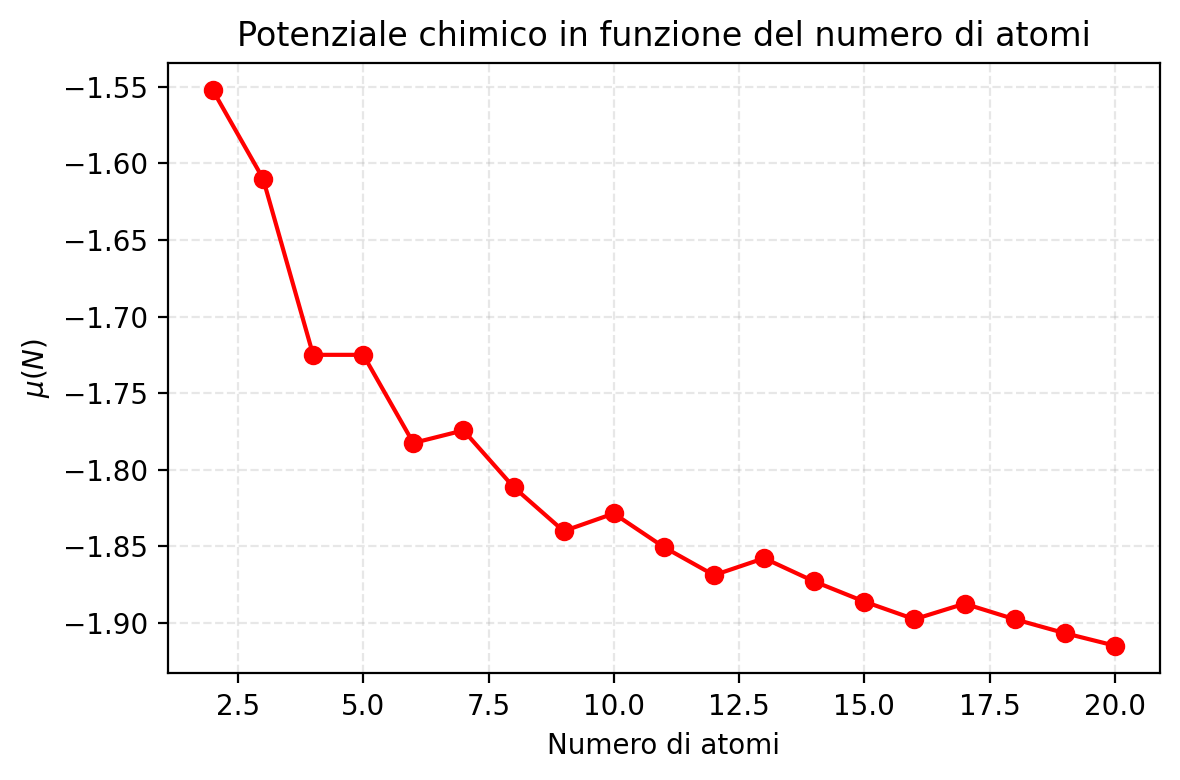

In [7]:
# plot energia/N v N
plt.figure(figsize=(6, 4), dpi=200)

x2 = N_atoms# da 2 atomi a 20
y2 = [best_results_dict[N].min_energy/N for N in N_atoms]

plt.plot(x2, y2, marker='o', color='red')
plt.xlabel('Numero di atomi')
plt.ylabel(r'$\mu(N)$')
plt.title('Potenziale chimico in funzione del numero di atomi')
plt.grid(linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
for N in N_atoms:
    print(f"{N}:", best_results_dict[N].min_energy/N)

2: -1.5524999999999998
3: -1.6099999999999997
4: -1.7249999999999996
5: -1.725
6: -1.7825000000000006
7: -1.7742857142857151
8: -1.8112500000000007
9: -1.8400000000000003
10: -1.8284999999999996
11: -1.850454545454545
12: -1.8687499999999984
13: -1.8576923076923064
14: -1.8728571428571412
15: -1.8859999999999983
16: -1.8974999999999982
17: -1.887352941176469
18: -1.8974999999999984
19: -1.906578947368419
20: -1.914749999999998


## Grafici insieme con assi sfalsate

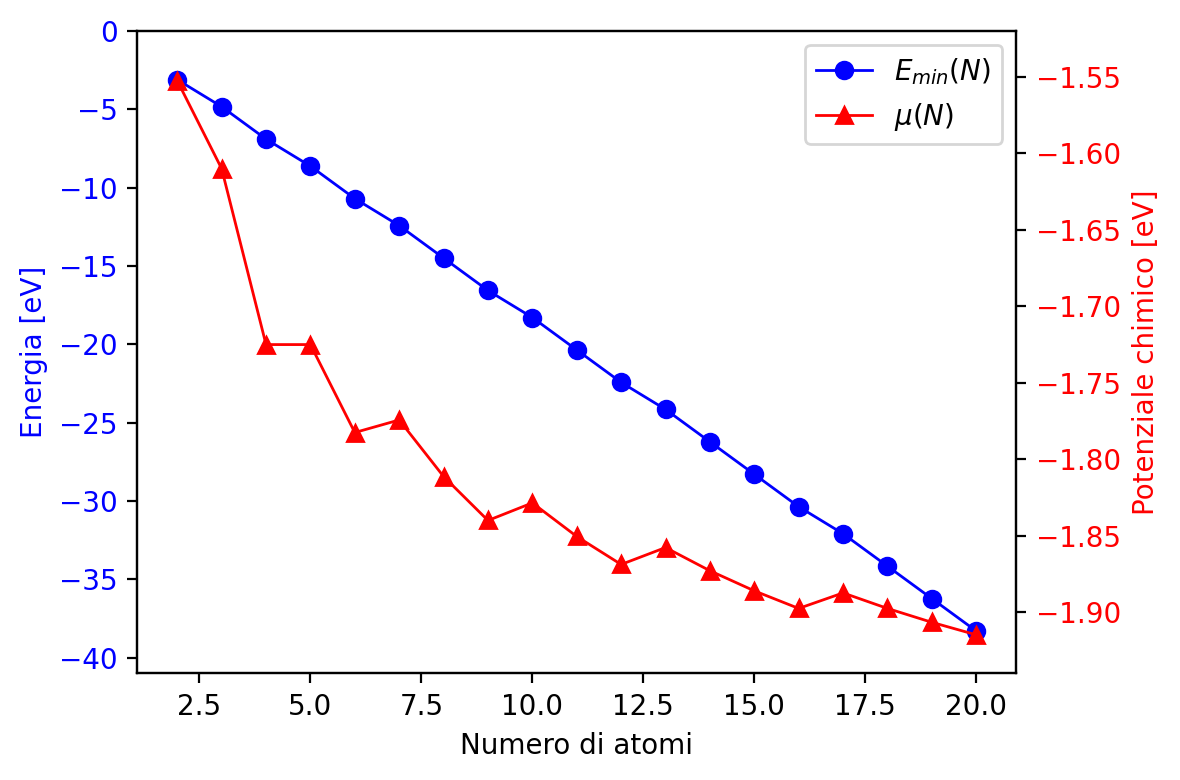

In [9]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

# Curva 1: energia, asse Y sinistro
ln1 = ax.plot(x1, y1, color='blue', label=r'$E_{{min}}(N)$', linewidth=1.0, marker='o')
ax.set_xlabel('Numero di atomi')
ax.set_ylabel('Energia [eV]', color='blue')
ax.tick_params(axis='y', labelcolor='blue')
#ax.grid(True, alpha=0.3)

# Range richiesto -41 → 0 (asse invertito)
ax.set_ylim(-41, 0)

# Curva 2: potenziale chimico, asse Y destro
ax2 = ax.twinx()
ln2 = ax2.plot(x2, y2, color='red', linestyle='-', label=r'$\mu(N)$', linewidth=1.0, marker='^')
ax2.set_ylabel('Potenziale chimico [eV]', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Range richiesto -1.94 → -1.52 (asse invertito)
ax2.set_ylim(-1.94, -1.52)

# Legenda combinata
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='best')

fig.tight_layout()
#fig.savefig("S11-vs-frequenza.pdf", bbox_inches='tight')
plt.show()